In [1]:
# %%
import sys
sys.path.append('..')
import utils
import os
import pathlib
import argparse
from tensorboardX import SummaryWriter
import logging
from datetime import datetime
import torch 
import mymodels 
import mydataset 
from torch.utils.data import DataLoader
from utils.myfed import *
import yaml
# %%


/home/suncheol/code/FedTest/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

yamlfilepath = pathlib.Path.cwd().parent.joinpath('config.yaml')
args = yaml.load(yamlfilepath.open('r'), Loader=yaml.FullLoader)
args = argparse.Namespace(**args)
args.datapath = "~/.data"
args.batchsize = 200
os.environ['CUDA_VISIBLE_DEVICES']=args.gpu

# 1. data
args.datapath = os.path.expanduser(args.datapath)

if args.dataset == 'cifar10':
    publicdata = 'cifar100'
    args.N_class = 10
elif args.dataset == 'cifar100':
    publicdata = 'imagenet'
    args.N_class = 100
elif args.dataset == 'pascal_voc2012':
    publicdata = 'mscoco'
    args.N_class = 20

assert args.dataset in ['cifar10', 'cifar100', 'pascal_voc2012']

priv_data, _, test_dataset, public_dataset, distill_loader = mydataset.data_cifar.dirichlet_datasplit(
    args, privtype=args.dataset, publictype=publicdata, N_parties=args.N_parties, online=not args.oneshot, public_percent=args.public_percent)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batchsize, shuffle=False, num_workers=args.num_workers, sampler=None)
val_loader = DataLoader(
    dataset=public_dataset, batch_size=args.batchsize, shuffle=False, num_workers=args.num_workers, sampler=None)


pascal_voc2012 mscoco
size of public dataset:  (32467, 3, 224, 224) images
size of test dataset:  (5823, 3, 224, 224) images
size of split_arr: (20, 5)
y label : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]]
Party_0 data shape: (809, 3, 224, 224)
Party_1 data shape: (1011, 3, 224, 224)
Party_2 data shape: (1132, 3, 224, 224)
Party_3 data shape: (1162, 3, 224, 224)
Party_4 data shape: (1165, 3, 224, 224)
Public data shape: (32467, 3, 224, 224)
Test data shape: (5823, 3, 224, 224)


In [7]:
args.model_name = 'vit_tiny_patch16_224'

In [8]:
net = mymodels.define_model(modelname=args.model_name, num_classes=args.N_class)
net 

DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate=none)
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop2): Dropout(p=0.0, inplace=False)
   

In [4]:
n = 0
loadname = os.path.join("/home/suncheol/code/VFL/FedMAD/checkpoints_backup/pascal_voc2012/a1.0+sd1+e300+b16+lkl", str(n)+'.pt')
if os.path.exists(loadname):
    localmodels = torch.load(loadname)
    #self.localmodels[n].load_state_dict(self.best_statdict, strict=True)
    logging.info(f'Loading Local{n}......')
    print('filepath : ', loadname)
    utils.load_dict(loadname, net)

In [9]:
loadname = os.path.join("/home/suncheol/code/FedTest/FedMAD/checkpoints/pascal_voc2012/a1.0+sd1+e300+b16+lkl/model-0.pth")
loadname = os.path.join("/home/suncheol/code/FedTest/FedMAD2/checkpoints/pascal_voc2012/a1.0+sd1+e300+b128+lkl+slmha/oneshot_c1_q0.0_n0.0/q0.0_n0.0_ADAM_b128_5e-05_200_5e-05_m0.9_e10_0.66.pt")
# loadname = os.path.join("/home/suncheol/code/FedTest/pytorch-models/checkpoint/pascal_voc_vit_tiny_patch16_224_0.0001_-1/ckpt.pth")
if os.path.exists(loadname):
    localmodels = torch.load(loadname)
    #self.localmodels[n].load_state_dict(self.best_statdict, strict=True)
    logging.info(f'Loading Local......')
    print('filepath : ', loadname)
    utils.load_dict(loadname, net)

filepath :  /home/suncheol/code/FedTest/FedMAD2/checkpoints/pascal_voc2012/a1.0+sd1+e300+b128+lkl+slmha/oneshot_c1_q0.0_n0.0/q0.0_n0.0_ADAM_b128_5e-05_200_5e-05_m0.9_e10_0.66.pt


In [10]:
import copy
models = []
for i in range(0, 5):
    model = copy.deepcopy(net)
    loadname = os.path.join(f"/home/suncheol/code/FedTest/FedMAD2/checkpoints/pascal_voc2012/a1.0+sd1+e300+b128+lkl+slmha/model-{i}.pth")
    # loadname = os.path.join(f"/home/suncheol/code/FedTest/pytorch-models/checkpoint/pascal_voc_vit_tiny_patch16_224_0.0001_{i}/ckpt.pth")
    if os.path.exists(loadname):
        localmodels = torch.load(loadname)
        #self.localmodels[n].load_state_dict(self.best_statdict, strict=True)
        logging.info(f'Loading Local......', 'filepath : ', loadname)
        utils.load_dict(loadname, model)
    models.append(model)

In [ ]:
len(models)

5

In [11]:
# show 1 batch of data
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(test_loader)
images, labels, _ = dataiter.next()


In [12]:
VOC_CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
# multi label to multi captions
def multi_label_to_multi_captions(labels):
    captions = []
    for label in labels:
        caption = []
        for i in range(len(label)):
            if label[i] == 1:
                caption.append(VOC_CLASSES[i])
        captions.append(caption)
    return captions
labels = multi_label_to_multi_captions(labels)

In [14]:
grad_cam_images = []
pred_labels = []
for model in models:
    grad_cam_images.append(model.module.get_class_activation_map(images, labels))
    m = torch.nn.Sigmoid()
    th = 0.3
    outputs = m(model(images)).detach().cpu().numpy()
    outputs[outputs > th] = 1
    outputs[outputs <= th] = 0
    pred = multi_label_to_multi_captions(outputs)
    pred_labels.append(pred)
# grayscale_cam = net.module.get_class_activation_map(images, labels)


In [35]:
central_grad_cam_images = []
central_model = copy.deepcopy(net)
central_grad_cam_images.append(central_model.module.get_class_activation_map(images, labels))
m = torch.nn.Sigmoid()
th = 0.3
outputs = m(central_model(images)).detach().cpu().numpy()
outputs[outputs > th] = 1
outputs[outputs <= th] = 0
central_pred_labels = multi_label_to_multi_captions(outputs)

In [36]:
grad_cam_images = torch.stack([torch.tensor(grad_cam_images[i]) for i in range(len(grad_cam_images))])
grad_cam_images.shape # n_clients * b * 224 * 224

/tmp/ipykernel_294710/3813428984.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grad_cam_images = torch.stack([torch.tensor(grad_cam_images[i]) for i in range(len(grad_cam_images))])


torch.Size([5, 200, 224, 224])

In [37]:
union_cam = torch.max(grad_cam_images, dim=0)[0]
intersection_cam = torch.min(grad_cam_images, dim=0)[0]
union_cam.cpu().shape

torch.Size([200, 224, 224])

In [38]:
labels

[['tvmonitor'],
 ['person', 'train'],
 ['boat'],
 ['cow'],
 ['tvmonitor'],
 ['aeroplane'],
 ['dog', 'person'],
 ['car'],
 ['bus', 'person'],
 ['bottle', 'person'],
 ['car'],
 ['chair', 'diningtable'],
 ['car'],
 ['bottle', 'chair', 'person'],
 ['car', 'person'],
 ['bird'],
 ['cat'],
 ['dog'],
 ['cat'],
 ['aeroplane'],
 ['chair', 'person'],
 ['cow'],
 ['bus'],
 ['horse'],
 ['dog'],
 ['dog'],
 ['boat', 'motorbike', 'person'],
 ['sheep'],
 ['bicycle', 'person'],
 ['chair'],
 ['cat', 'chair'],
 ['cat'],
 ['horse'],
 ['boat'],
 ['bird'],
 ['bicycle', 'car'],
 ['bird'],
 ['dog', 'person'],
 ['boat'],
 ['bottle', 'tvmonitor'],
 ['chair', 'sofa'],
 ['car'],
 ['car'],
 ['horse'],
 ['cat'],
 ['dog'],
 ['train'],
 ['bicycle', 'person'],
 ['boat', 'person'],
 ['car', 'motorbike', 'person'],
 ['person'],
 ['person'],
 ['person'],
 ['horse'],
 ['cat', 'person'],
 ['person'],
 ['person'],
 ['person'],
 ['dog'],
 ['person'],
 ['tvmonitor'],
 ['chair', 'person'],
 ['aeroplane', 'car'],
 ['car'],
 ['per

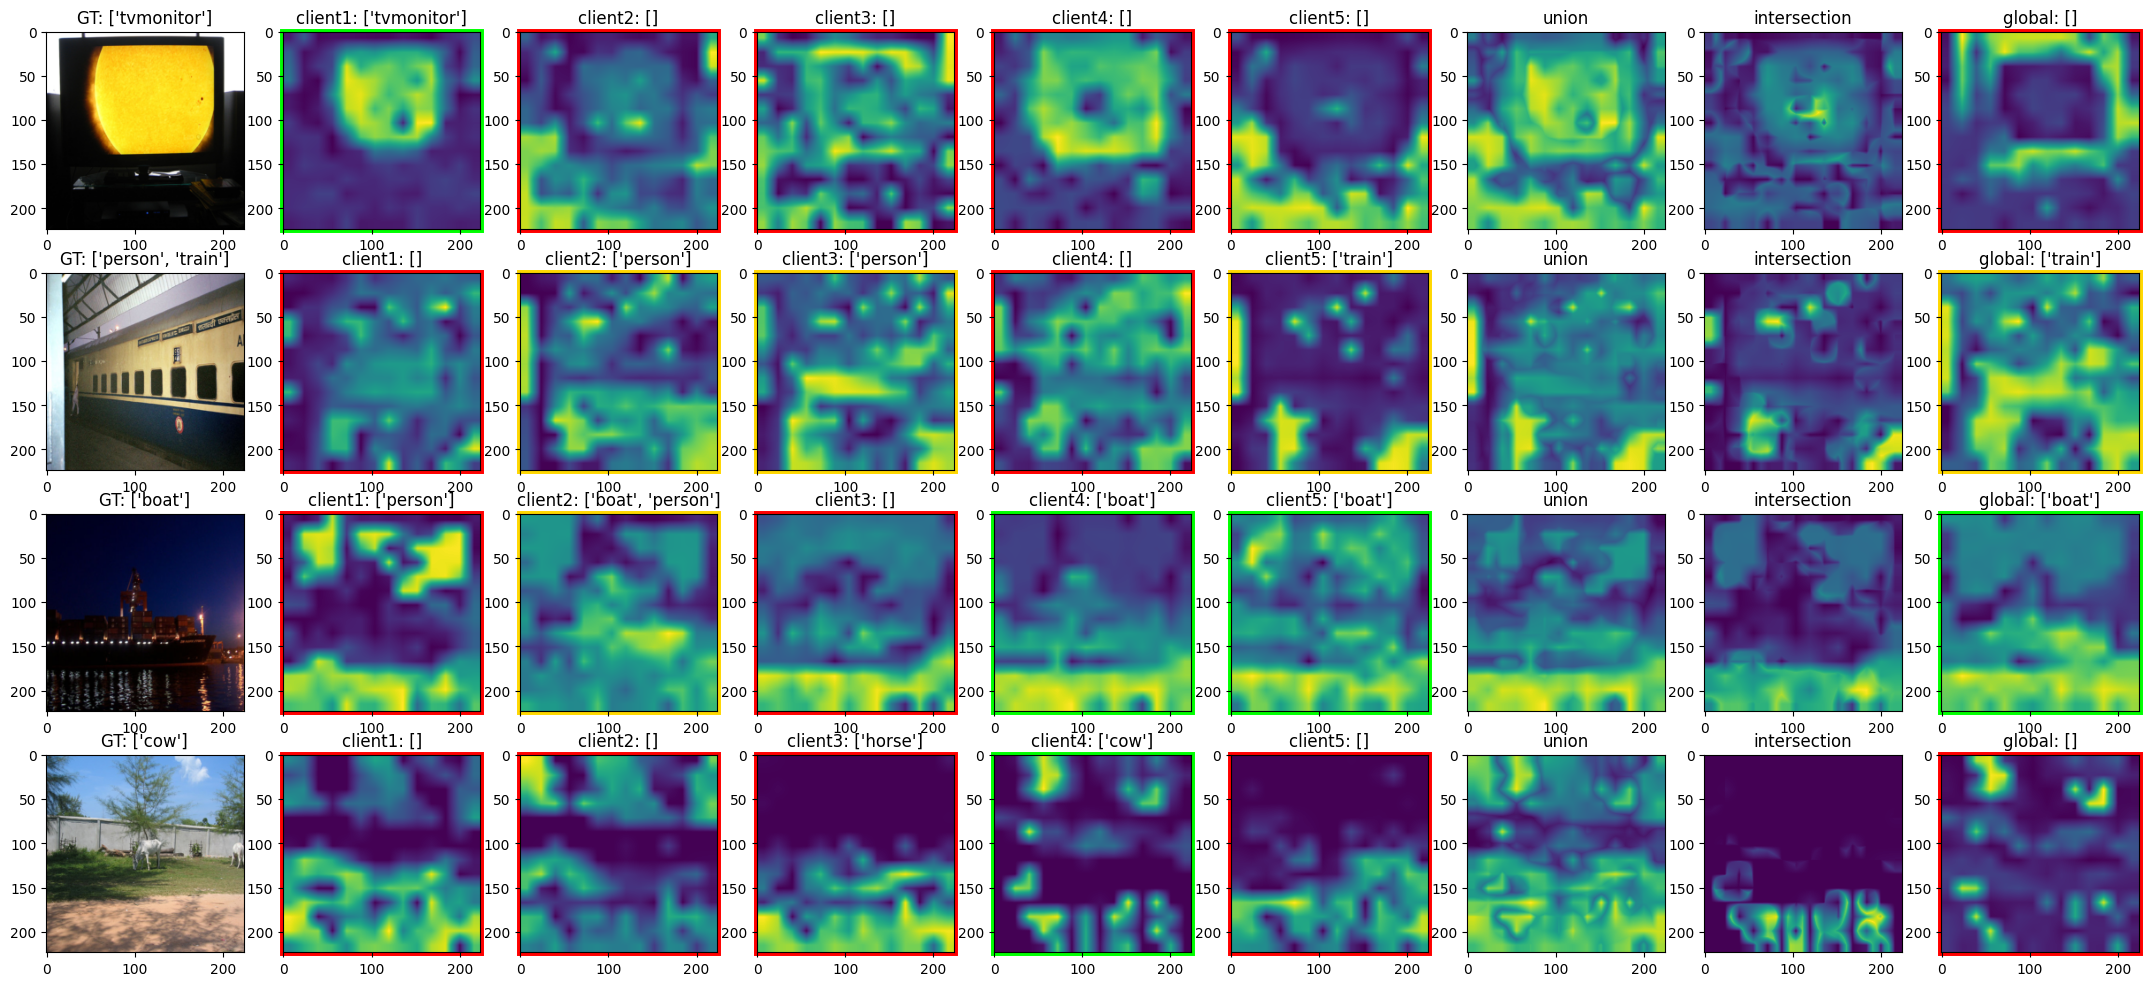

In [40]:
%matplotlib inline
def get_border_color(true_label, pred_label):
    if pred_label == true_label:
        return 'lime'  # green
    elif set(pred_label) & set(true_label):
        return 'gold'  # yellow
    else:
        return 'red'

row = 4
col = 9
clients = 5
extra_plots = 3  # union, intersection, global

import matplotlib.pyplot as plt
plt.figure(figsize=(3 * col, 3 * row))

for j in range(row):
    true_label = labels[j]
    for i in range(clients + extra_plots + 1):
        ax = plt.subplot(row, col, j * col + i + 1)
        # print(i, j)
        if i == 0:
            img = images[j].cpu().permute(1, 2, 0)
            plt.imshow(img)
            plt.title(f'GT: {true_label}')
        elif i <= clients:
            img = grad_cam_images[i - 1].cpu()[j]
            pred_label = pred_labels[i - 1][j]
            border_color = get_border_color(true_label, pred_label)
            plt.imshow(img)
            # set border color
            ax.patch.set_edgecolor(border_color)
            ax.patch.set_linewidth(5)
            plt.title(f'client{i}: {pred_label}')
        elif i == clients + 1:
            img = union_cam.cpu()[j]
            plt.imshow(img)
            plt.title('union')
        elif i == clients + 2:
            img = intersection_cam.cpu()[j]
            plt.imshow(img)
            plt.title('intersection')
        elif i == clients + 3:
            img = central_grad_cam_images[0][j]
            border_color = get_border_color(true_label, central_pred_labels[j])
            plt.imshow(img)
            plt.title(f'global: {central_pred_labels[j]}')
            ax.patch.set_edgecolor(border_color)
            ax.patch.set_linewidth(5)
        # plt.gca().set_xticks([])
        # plt.gca().set_yticks([])
        # plt.gca().spines['top'].set_visible(False)
        # plt.gca().spines['right'].set_visible(False)
        # plt.gca().spines['bottom'].set_visible(False)
        # plt.gca().spines['left'].set_visible(False)

plt.show()
# plt.tight_layout()

In [52]:
correct_dict = {}
for idx, (true_label, central_pred) in enumerate(zip(labels, central_pred_labels)):
    correct_clients_count = sum(client_pred[idx] == true_label for client_pred in pred_labels)
    correct_central = central_pred == true_label
    correct_dict[idx] = (correct_clients_count, correct_central)

# correct_dict to dataframe
import pandas as pd
df = pd.DataFrame.from_dict(correct_dict, orient='index', columns=['correct_clients_count', 'correct_central'])
df = df.pivot_table(index='correct_clients_count', columns='correct_central', aggfunc=len, fill_value=0)
df.T

correct_clients_count   0   1   2   3   4   5
correct_central                              
False                  61  18   7   4   2   0
True                    1  12  10  14  34  37

In [54]:
def find_wrong_clients_correct_central(true_labels, client_pred_labels, central_pred_labels):
    result_indices = []
    for idx, (true_label, central_pred) in enumerate(zip(true_labels, central_pred_labels)):
        if sum(client_pred[idx] == true_label for client_pred in client_pred_labels) < 2 and central_pred == true_label:
            result_indices.append(idx)
    return result_indices

def find_correct_clients_wrong_central(true_labels, client_pred_labels, central_pred_labels):
    result_indices = []
    for idx, (true_label, central_pred) in enumerate(zip(true_labels, central_pred_labels)):
        # if all(client_pred[idx] == true_label for client_pred in client_pred_labels) and central_pred != true_label:
        #     result_indices.append(idx)
        # more than 3 clients are correct and central is wrong
        if sum(client_pred[idx] == true_label for client_pred in client_pred_labels) > 3 and central_pred != true_label:
            result_indices.append(idx)
            
    return result_indices

# Example usage
wrong_clients_correct_central_indices = find_wrong_clients_correct_central(labels, pred_labels, central_pred_labels[0])
print("Wrong clients, correct central indices:", wrong_clients_correct_central_indices)

correct_clients_wrong_central_indices = find_correct_clients_wrong_central(labels, pred_labels, central_pred_labels[0])
print("Correct clients, wrong central indices:", correct_clients_wrong_central_indices)

Wrong clients, correct central indices: []
Correct clients, wrong central indices: []


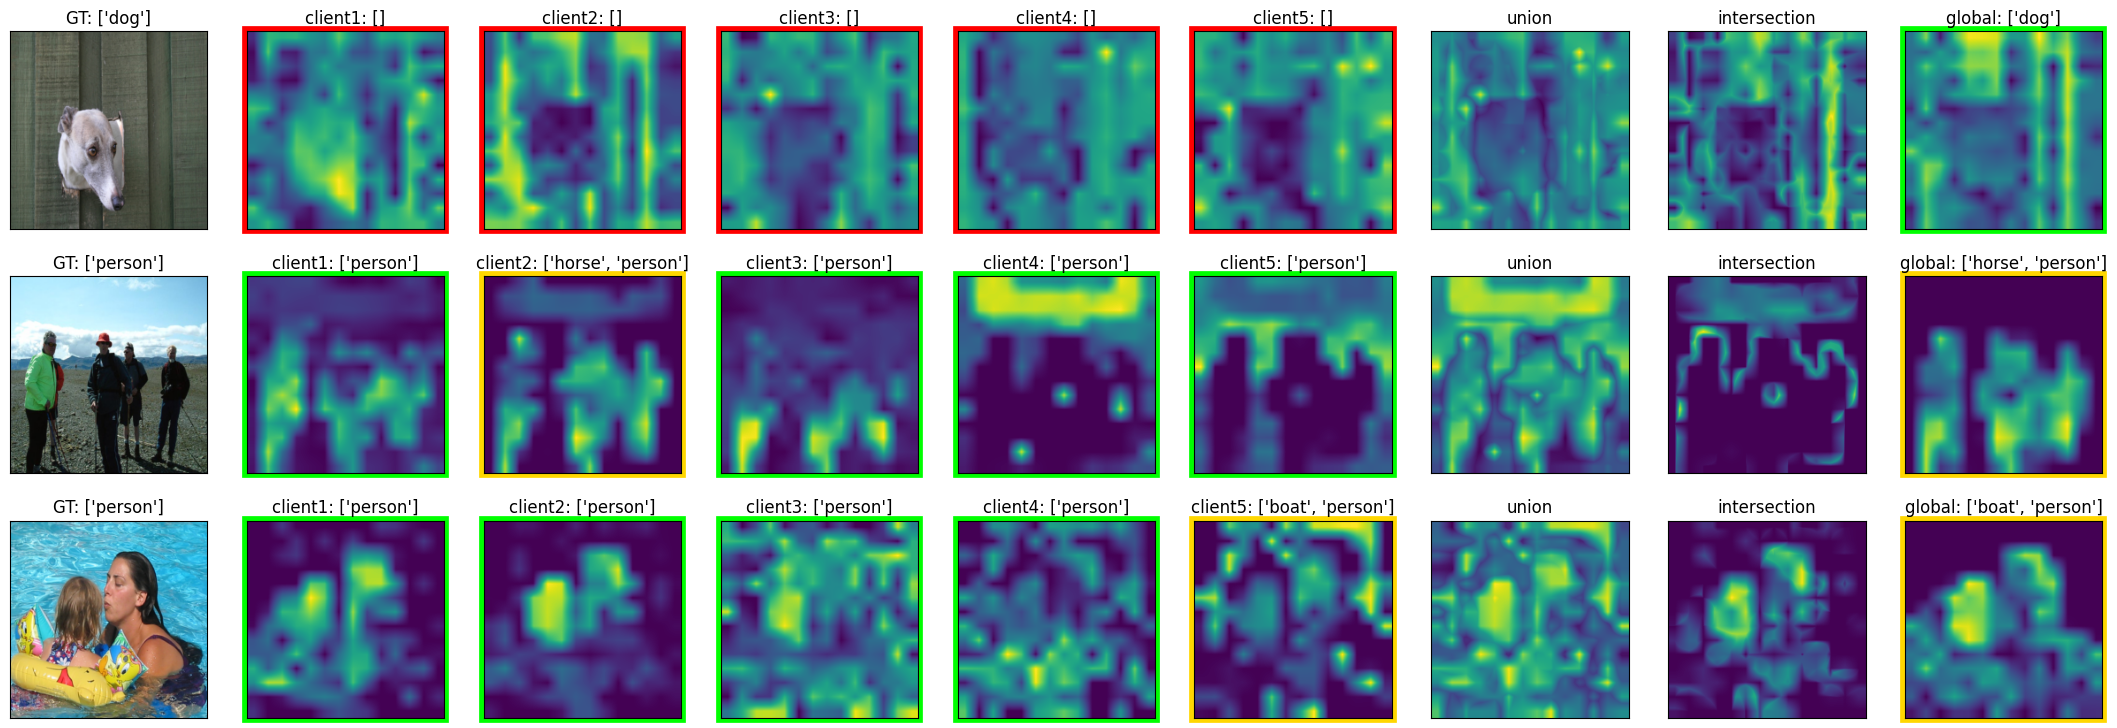

In [56]:
%matplotlib inline
def get_border_color(true_label, pred_label):
    if pred_label == true_label:
        return 'lime'  # green
    elif set(pred_label) & set(true_label):
        return 'gold'  # yellow
    else:
        return 'red'
image_index = [58, 110, 127]
row = len(image_index)
col = 9
clients = 5
extra_plots = 3  # union, intersection, global

import matplotlib.pyplot as plt
plt.figure(figsize=(3 * col, 3 * row))

for j in range(row):
    idxImage = image_index[j]
    true_label = labels[idxImage]
    for i in range(clients + extra_plots + 1):
        ax = plt.subplot(row, col, j * col + i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        # print(i, idxImage)
        if i == 0:
            img = images[idxImage].cpu().permute(1, 2, 0)
            plt.imshow(img)
            plt.title(f'GT: {true_label}')
        elif i <= clients:
            img = grad_cam_images[i - 1].cpu()[idxImage]
            pred_label = pred_labels[i - 1][idxImage]
            border_color = get_border_color(true_label, pred_label)
            plt.imshow(img)
            # set border color
            ax.patch.set_edgecolor(border_color)
            ax.patch.set_linewidth(7)
            plt.title(f'client{i}: {pred_label}')
        elif i == clients + 1:
            img = union_cam.cpu()[idxImage]
            plt.imshow(img)
            plt.title('union')
        elif i == clients + 2:
            img = intersection_cam.cpu()[idxImage]
            plt.imshow(img)
            plt.title('intersection')
        elif i == clients + 3:
            img = central_grad_cam_images[0][idxImage]
            border_color = get_border_color(true_label, central_pred_labels[idxImage])
            plt.imshow(img)
            plt.title(f'global: {central_pred_labels[idxImage]}')
            ax.patch.set_edgecolor(border_color)
            ax.patch.set_linewidth(7)
        # plt.gca().set_xticks([])
        # plt.gca().set_yticks([])
        # plt.gca().spines['top'].set_visible(False)
        # plt.gca().spines['right'].set_visible(False)
        # plt.gca().spines['bottom'].set_visible(False)
        # plt.gca().spines['left'].set_visible(False)

plt.savefig('test.png')
plt.show()
# plt.tight_layout()

In [57]:
mha_images = [] 
th_images = []
for model in models:
    mha, th = model.module.get_attention_maps_postprocessing_(images.cuda())
    mha_images.append(mha)
    th_images.append(th)
    
mha_images = torch.stack([torch.tensor(mha_images[i]) for i in range(len(mha_images))])
th_images = torch.stack([torch.tensor(th_images[i]) for i in range(len(th_images))])
mha_images.shape # n_clients * b * 224 * 224
th_images.shape # n_clients * b * 224 * 224
print(mha_images.shape, th_images.shape)


torch.Size([5, 200, 3, 224, 224]) torch.Size([5, 200, 3, 224, 224])


In [58]:
central_mha, central_th = central_model.module.get_attention_maps_postprocessing_(images.cuda())

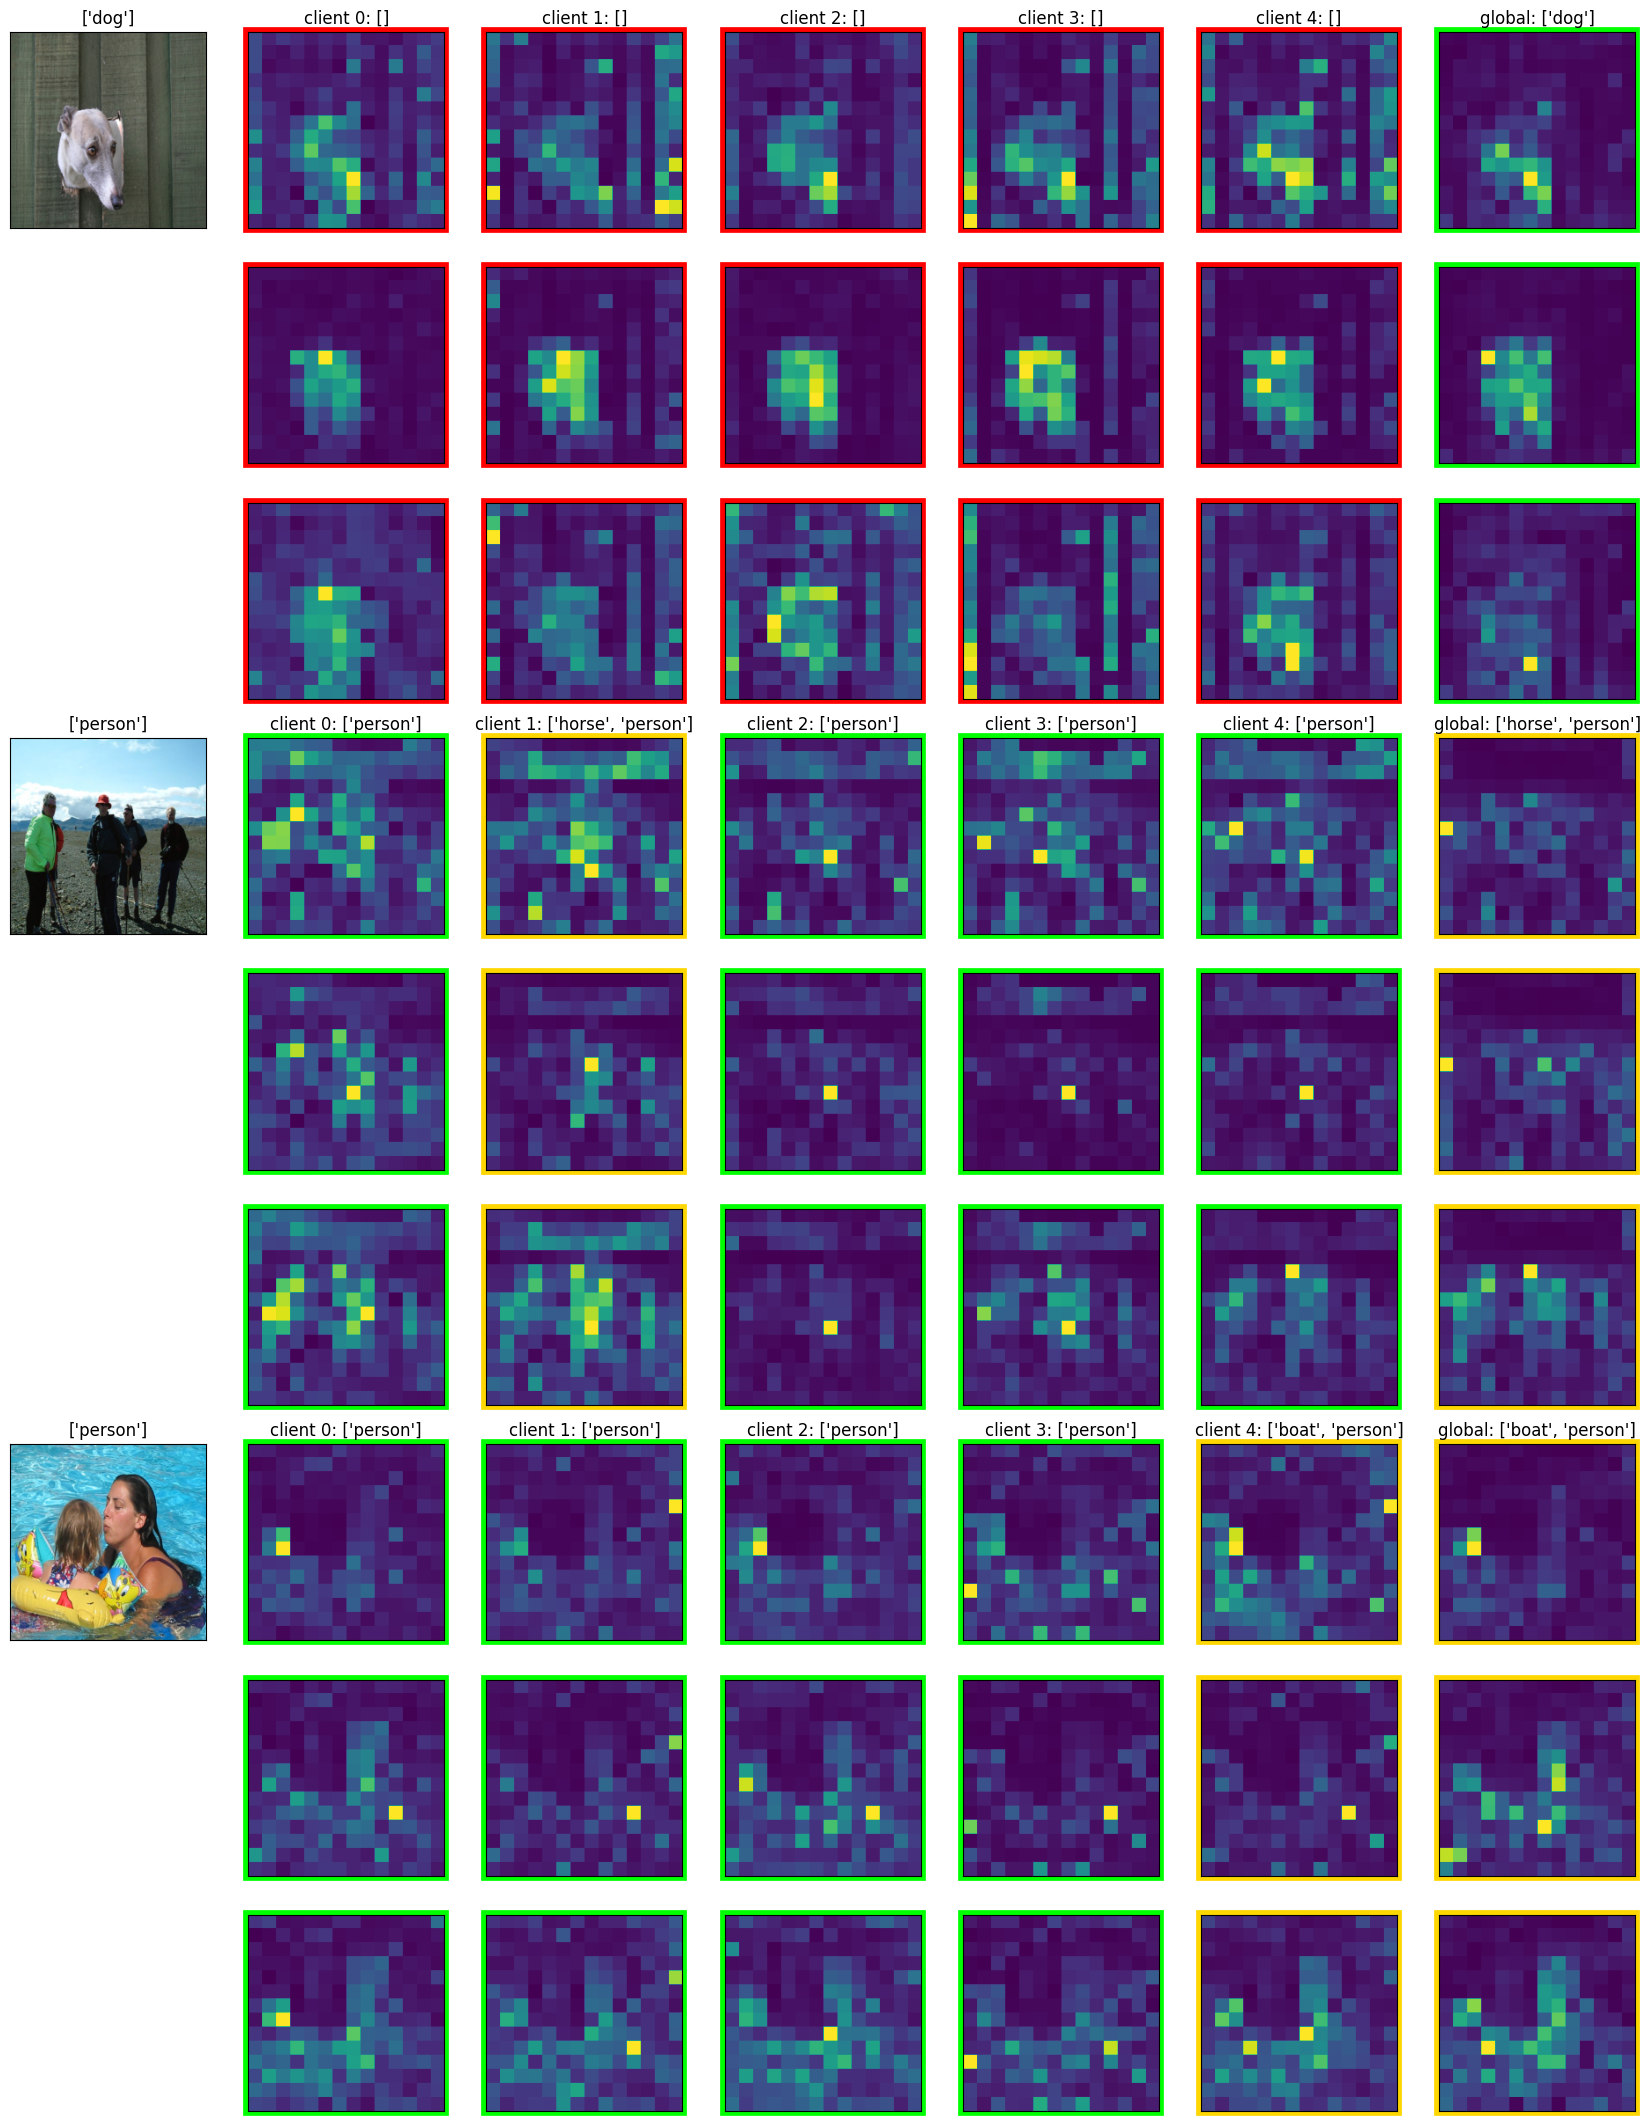

<Figure size 640x480 with 0 Axes>

In [59]:
def plot_mha_images(images, labels, mha_images, pred_labels, central_mha, central_pred_labels):
    n_clients, n_images, n_head, h, w = mha_images.shape
    image_indices = [58, 110, 127]
    row = len(image_indices) * n_head
    col = 1 + n_clients + 1
    plt.figure(figsize=(3 * col, 3 * row))
    for j in range(0, row):
        _j = j // n_head
        img_index = image_indices[_j]
        true_label = labels[img_index]
        k = j % n_head
        if k == 0:
            ax = plt.subplot(row, col, j * col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(images[img_index].numpy().transpose(1, 2, 0))
            plt.title(true_label)
        for i in range(0, n_clients):
            ax = plt.subplot(row, col, j * col + i + 2)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(mha_images[i, img_index, k, :, :].numpy())
            pred_label = pred_labels[i][img_index]
            border_color = get_border_color(true_label, pred_label)
            ax.patch.set_edgecolor(border_color)
            ax.patch.set_linewidth(7)
            if k == 0:
                plt.title(f'client {i}: {pred_label}')
        ax = plt.subplot(row, col, j * col + n_clients + 2)
        plt.imshow(central_mha[img_index, k, :, :])
        ax.set_xticks([])
        ax.set_yticks([])
        central_pred_label = central_pred_labels[img_index]
        border_color = get_border_color(true_label, central_pred_label)
        ax.patch.set_edgecolor(border_color)
        ax.patch.set_linewidth(7)

        if k == 0:
            plt.title(f'global: {central_pred_label}')
    plt.savefig('test2.png')
    plt.show()
    plt.tight_layout()

# Usage
plot_mha_images(images, labels, mha_images, pred_labels, central_mha, central_pred_labels)

In [60]:
mha_images.shape

torch.Size([5, 200, 3, 224, 224])

In [ ]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 파라미터 정의
num_client = 5
batchsize = 128
num_head = 3
imagesize_width = 224
imagesize_height = 224

# PCA를 수행하기 위해 데이터를 적절한 형태로 변환합니다.
reshaped_mha_images = mha_images.reshape(num_client, batchsize, num_head, -1)

# 각 헤드에 대해 PCA 수행
for head_idx in range(num_head):
    pca_input = reshaped_mha_images[:, :, head_idx, :].reshape(num_client * batchsize, -1).detach().numpy()

    # PCA 수행
    pca = PCA(n_components=2)
    pca_output = pca.fit_transform(pca_input)

    # 결과 시각화
    for client_idx in range(num_client):
        start_idx = client_idx * batchsize
        end_idx = (client_idx + 1) * batchsize
        mean_coordinate = np.mean(pca_output[start_idx:end_idx, :], axis=0)
        plt.scatter(mean_coordinate[0], mean_coordinate[1], label=f'Client {client_idx + 1}, Head {head_idx + 1}')

# 시각화 옵션 설정 및 표시
plt.legend()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Multihead Attention Maps per Head')
plt.show()
    


In [ ]:
import torch
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 파라미터 정의
num_client = 5
batchsize = 128
num_head = 3
imagesize_width = 224
imagesize_height = 224

# PCA를 수행하기 위해 데이터를 적절한 형태로 변환합니다.
reshaped_mha_images = mha_images.reshape(num_client, batchsize, num_head, -1)

# 색상 팔레트 설정
palette = sns.color_palette("husl", num_head)

# 각 헤드에 대해 PCA 수행
for head_idx in range(num_head):
    pca_input = reshaped_mha_images[:, :, head_idx, :].reshape(num_client * batchsize, -1).detach().numpy()

    # PCA 수행
    pca = PCA(n_components=5)
    pca_output = pca.fit_transform(pca_input)

    # 결과 시각화
    for client_idx in range(num_client):
        start_idx = client_idx * batchsize
        end_idx = (client_idx + 1) * batchsize
        # mean_coordinate = np.mean(pca_output[start_idx:end_idx, :], axis=0)
        # plt.scatter(mean_coordinate[0], mean_coordinate[1], label=f'Client {client_idx + 1}, Head {head_idx + 1}', color=palette[head_idx])
        plt.scatter(pca_output[start_idx:end_idx, 0], pca_output[start_idx:end_idx, 1], label=f'Client {client_idx + 1}, Head {head_idx + 1}', color=palette[head_idx])

# 시각화 옵션 설정 및 표시
# set legend position to outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Average PCA Coordinates of Multihead Attention Maps per Head and Client')
plt.show()

In [ ]:
import torch
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 파라미터 정의
num_client = 5
batchsize = 128
num_head = 3
imagesize_width = 224
imagesize_height = 224

# 클러스터 수 정의
num_clusters = 3

# PCA를 수행하기 위해 데이터를 적절한 형태로 변환합니다.
reshaped_mha_images = mha_images.reshape(num_client, batchsize, num_head, -1)
# batchsize = 1 
# reshaped_mha_images = reshaped_mha_images[:, 0, :, :].reshape(num_client, batchsize, num_head, -1)
print(reshaped_mha_images.shape)

# 색상 팔레트 설정
palette = sns.color_palette("husl", num_clusters)

# 각 헤드에 대해 t-SNE 및 K-means 클러스터링 수행

for head_idx in range(num_head):
    tsne_input = reshaped_mha_images[:, :, head_idx, :].reshape(num_client * batchsize, -1).detach().numpy()
    print(tsne_input.shape)
    
    # t-SNE 수행
    tsne = TSNE(n_components=2, random_state=0)
    tsne_output = tsne.fit_transform(tsne_input.astype(np.float64))  # 데이터 형식을 double로 변환

    # K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(tsne_output)

    # 결과 시각화
    for client_idx in range(num_client):
        start_idx = client_idx * batchsize
        end_idx = (client_idx + 1) * batchsize
        coordinates = tsne_output[start_idx:end_idx, :]
        for i, coord in enumerate(coordinates):
            plt.scatter(coord[0], coord[1], label=f'Client {client_idx + 1}, Head {head_idx + 1}', color=palette[head_idx])

# 시각화 옵션 설정 및 표시
# plt.legend()
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-means Clustering of Average t-SNE Coordinates of Multihead Attention Maps per Head and Client')
plt.show()


/home/suncheol/code/FedTest/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/suncheol/code/FedTest/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


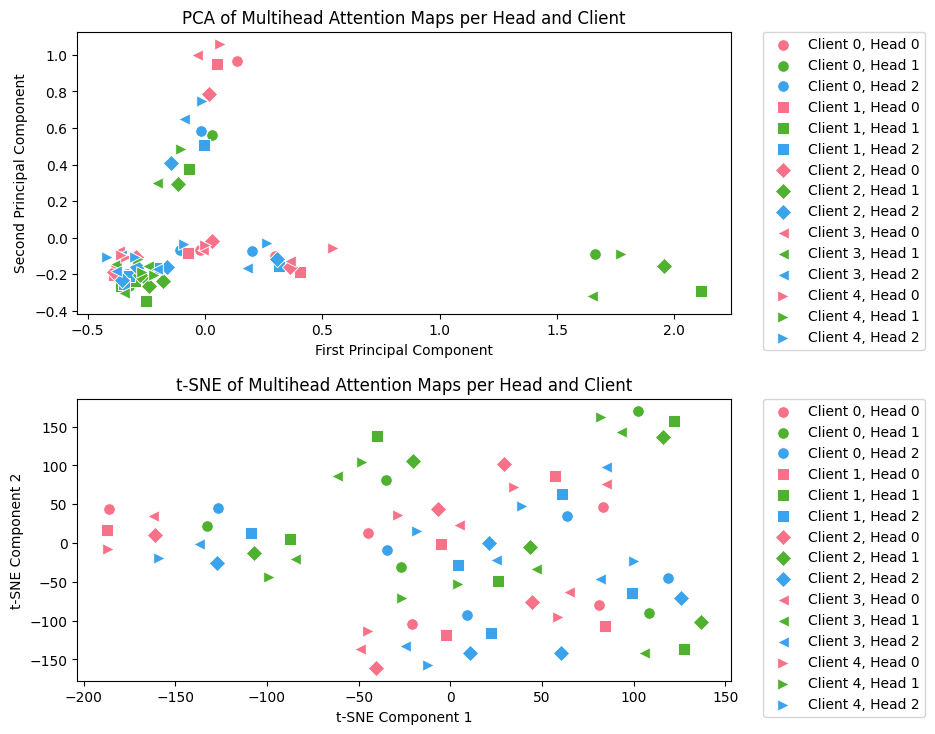

In [85]:
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

num_client = 5
batchsize = 200
num_head = 3
imagesize_width = 224
imagesize_height = 224

batchsize = 200
used_batchsize = 5

temp_mha_images = mha_images[:, :used_batchsize, :, :]
# 데이터 전처리
head_images = []
for client_idx in range(num_client):
    for head_idx in range(num_head):
        head_images.append(temp_mha_images[client_idx, :, head_idx].view(-1, imagesize_width * imagesize_height).numpy())

head_images = np.vstack(head_images)


# PCA 모델 생성 및 학습
pca = PCA(n_components=2, random_state=42)
pca_images = pca.fit_transform(head_images)

marker_list = ["o", "s", "D", "<", ">"]
palette = sns.color_palette("husl", num_head)

# t-SNE 결과 시각화
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)

for client_idx in range(num_client):
    for head_idx in range(num_head):
        idx = client_idx * num_head + head_idx
        start_idx = idx * used_batchsize
        end_idx = (idx + 1) * used_batchsize
        sns.scatterplot(
            x=pca_images[start_idx:end_idx, 0],
            y=pca_images[start_idx:end_idx, 1],
            label=f"Client {client_idx}, Head {head_idx}",
            color=palette[head_idx],
            marker=marker_list[client_idx],
            s=70
        )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA of Multihead Attention Maps per Head and Client")

# t-SNE 모델 생성 및 학습
tsne = TSNE(n_components=2, random_state=42)
tsne_images = tsne.fit_transform(head_images)

# t-SNE 결과 시각화
plt.subplot(2, 1, 2)
for client_idx in range(num_client):
    for head_idx in range(num_head):
        idx = client_idx * num_head + head_idx
        start_idx = idx * used_batchsize
        end_idx = (idx + 1) * used_batchsize
        sns.scatterplot(
            x=tsne_images[start_idx:end_idx, 0],
            y=tsne_images[start_idx:end_idx, 1],
            label=f"Client {client_idx}, Head {head_idx}",
            color=palette[head_idx],
            marker=marker_list[client_idx],
            s=70
        )
plt.tight_layout(pad=3.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE of Multihead Attention Maps per Head and Client")
plt.savefig("pca_tsne.png")

In [105]:
arange = 
arange

array([0, 1])

In [87]:
variance_df

Component  Explained Variance  Cumulative Explained Variance
0          1            0.390286                       0.390286
1          2            0.161823                       0.552109

/tmp/ipykernel_294710/2042926579.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Component', y='Explained Variance', data=variance_df, palette="Blues_d", ci=None)
/tmp/ipykernel_294710/2042926579.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=np.arange(0, 2), y='Cumulative Explained Variance', data=variance_df, ax=ax, color='r', marker='o', ci=None)


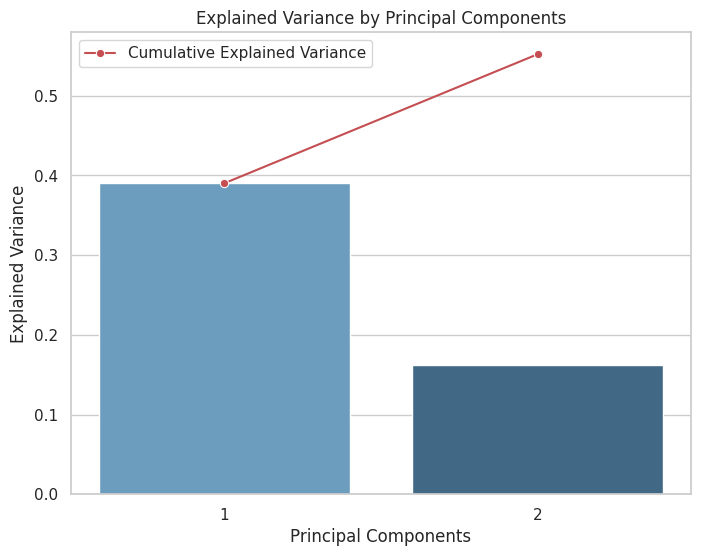

In [107]:
# 설명된 분산 계산
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# 설명된 분산과 누적 설명된 분산을 데이터프레임으로 변환
variance_df = pd.DataFrame({'Component': np.arange(1, len(explained_variance) + 1),
                            'Explained Variance': explained_variance,
                            'Cumulative Explained Variance': cumulative_explained_variance})

# 매트릭스 형태로 시각화
plt.figure(figsize=(8, 6))

sns.set(style="whitegrid")
ax = sns.barplot(x='Component', y='Explained Variance', data=variance_df, palette="Blues_d", ci=None)
sns.lineplot(x=np.arange(0, 2), y='Cumulative Explained Variance', data=variance_df, ax=ax, color='r', marker='o', ci=None)
# no grid
# ax2.grid(False)
# 라벨 설정
ax.set_xlabel('Principal Components')
ax.set_ylabel('Explained Variance')
# ax2.set_ylabel('Cumulative Explained Variance')
# 범례 추가
ax.legend(['Cumulative Explained Variance'], loc='upper left')
plt.title('Explained Variance by Principal Components')
plt.savefig("explained_variance.png")

plt.show()